In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

In [22]:
from datetime import datetime as dt, timedelta
import numpy as np
import pandas as pd
from bokeh.io import show, output_notebook
from zooscraper.globals import max_bulk_create
from casestudy.models import Deaths, Cases, Tests, Measurements, Pollutant

In [16]:
from datetime import datetime as dt, timedelta
import pandas as pd
from decouple import config

In [17]:
from casestudy.see19.see19 import CaseStudy, get_baseframe
from see19.constants import COUNT_TYPES

In [24]:
output_notebook()

Loading BokehJS ...

In [25]:
baseframe = get_baseframe()

In [51]:
countries = [
    'United States of America (the)',
    'Singapore'
]

factors_with_dmas = ['strindex']
factor_dmas = {factor: 28 for factor in factors_with_dmas}
mobi_dmas = {factor: 1 for factor in [*CaseStudy.GMOBIS, *CaseStudy.AMOBIS]}
factors = factors_with_dmas + CaseStudy.GMOBIS + ['A65PLUSB', 'A15_34B'] + CaseStudy.AMOBIS

casestudy = CaseStudy(
    baseframe, countries=countries, count_dma=3, factors=factors, 
    factor_dmas=factor_dmas, mobi_dmas=mobi_dmas, start_hurdle=dt(2020,4,15), start_factor='date', lognat=True,
    min_deaths=1,
)

In [63]:
CHARTPATH = config('ROOTPATH') + 'casestudy/covidcharts/charts/'
date = (dt.now().date() - timedelta(1)).strftime('%b %d')
twitter_height_for_matplotlib=3

In [53]:
[col for col in casestudy.df.columns if 'test' in col and 'case' in col]

['cases_per_test',
 'tests_per_case',
 'cases_dma_per_test_dma',
 'cases_new_per_test_new',
 'cases_new_dma_per_test_new_dma',
 'growth_cases_per_test',
 'growth_tests_per_case',
 'growth_cases_dma_per_test_dma',
 'growth_cases_new_per_test_new',
 'growth_cases_new_dma_per_test_new_dma']

In [61]:
regions = ['California', 'Texas', 'Florida']
twitter_height_for_bokeh=325
save_file = True
# title = 'cases'
# count_type = 'cases_new_dma_per_1M'
title = 'positivity'
count_type = 'cases_new_dma_per_test_new_dma'
title = 'Comparing {} as of {}'.format('New' + count_type.title() if title == 'cases' else 'Positivity Ratio', date)
filename = CHARTPATH + title + ' {}.png'.format(' '.join(regions))
kwargs ={    
    'title': title,
    'regions': regions,
    'comp_category': '{}'.format(count_type),
    'x_fontsize': 11, 
    'y_fontsize': 11,
    'fs_xticks': 8,
    'fs_yticks': 8,
    'fs_labels': 16,
    'fs_legend': 10,
    'legend': True,
    'legend_location': 'top_center',
    'legend_title': '',
    'height': twitter_height_for_bokeh,
    'width': 525,
    'bg_color': '#6883BA', 'bg_alpha': .02,
    'border_color': '#6883BA', 'border_alpha': .05,
    'multiline_labels': None,
    'save_file': save_file,
    'filename': filename,
}

p = casestudy.comp_chart.make(comp_type='multiline', **kwargs)
show(p)

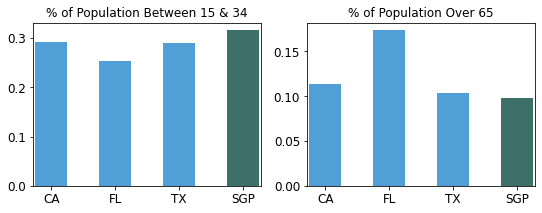

In [68]:
factors6 = ['A15_34B_%', 'A65PLUSB_%']
kwargs = {'factors': factors6, 'height': 4, 'colors': ['#3D7068', '#D4AFB9', '#529FD7']}
kwargs['regions'] = ['California', 'Texas', 'Florida', 'Singapore']
kwargs['height'] = twitter_height_for_matplotlib
kwargs['width'] = 9
kwargs['feature_regions'] = ['SGP']
kwargs['save_file'] = True
kwargs['filename'] = filename = CHARTPATH + 'Population {}.png'.format(' '.join(regions))
plt = casestudy.barcharts.make(**kwargs)